## Отчет. Группа 3

In [ ]:
!pip install cvxpy numdifftools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cvxpy as cp
import numpy as np
import numdifftools as nd
import tqdm
import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_spd_matrix

**Задача:**

$\min{\{(x - \mu_0)^T \cdot A \cdot  (x - \mu_0) : \| x \|^2_2 \leq  1 \}}$, 
where $x \epsilon \mathbb{R}^n $, $A$ - symmetric positive definite matrix, 
$\mu_0$ is a vector of ones $= (1, 1, ..., 1)^T \epsilon \mathbb{R}^n$

### 1. Исследуйте задачу на выпуклость. Запишите необходимые условия минимума (находить минимум аналитически не нужно)

1. Выпуклость.

1.1 Функция ограничения в виде неравенства выпукла как сумма выпуклых $x_i^2$.

1.2. Рассмотрим выпуклость минимизируемой функции $ (x - \mu_0)^T \cdot A \cdot  (x - \mu_0) $, где $A$ - симметричная, положительно определенная матрица. Докажем выпуклость по критерию неотрицательной определенности матрицы Гессе.

Для удобства вместо $(x - \mu_0)$ будем писать просто $x$. 

Пусть $f = x^T \cdot A \cdot x$

$$\frac{\partial f}{\partial \mathbf x}=\begin{pmatrix} \frac{\partial f}{\partial  x_1}  \\ \vdots\\ \frac{\partial f}{\partial  x_n} \end{pmatrix}$$

\begin{align}
f = x^T \cdot A \cdot x = \sum_{i=1}^n\sum_{j=1}^n a_{ij}x_ix_j&=\sum_{i=1}^na_{i1}x_ix_1+\sum_{j=1}^na_{1j}x_1x_j+\sum_{i=2}^n\sum_{j=2}^n a_{ij}x_ix_j
\end{align}

Рассмотрим, например, $x_1$:
\begin{align}
\\\frac{\partial f}{\partial  x_1} &=\sum_{i=1}^na_{i1}x_i+\sum_{j=1}^na_{1j}x_j=\sum_{i=1}^na_{1i}x_i+\sum_{i=1}^na_{1i}x_i, (\text{так как матрица симметрична}), =2\sum_{i=1}^na_{1i}x_i
\end{align} 
Таким образом,
\begin{align}
\\ \frac{\partial f}{\partial \mathbf x}&=\begin{pmatrix} 2 \sum_{i=1}^na_{1i}x_i \\ \vdots\\ 2 \sum_{i=1}^na_{ni}x_i \end{pmatrix} \\&=2\begin{pmatrix} a_{11} & a_{12} & \dots & a_{1n}\\  \vdots & \vdots &\ddots & \vdots \\ a_{n1} & a_{n2} & \dots & a_{nn} \end{pmatrix}\begin{pmatrix}x_1  \\ \vdots \\ x_n \end{pmatrix}\\ &= 2A\mathbf x
\end{align} 
Тогда:

\begin{align}
\frac{\partial^2 f}{\partial \mathbf x^2} = 2A \succ 0, \text{так как A положительно определенная матрица}
\end{align}

Искомая задача выпукла. Теперь запишем необходимые условия минимума:



Критерий выпуклости: 
$\nabla f_0(x^*)^⊤(x − x^⋆) \geq 0 \space \forall x : f_1(x) \leq 0 \space. x^* \epsilon X$

Для задачи с одним ограничением неравенством возможны 2 случая:
1. $x^*$ лежит внутри области. Тогда $\nabla f_0(x^*)=0$
2. $x^*$ лежит на границе области. Тогда:

\begin{equation*}
     \begin{cases}
       f_1(x^*) = 0 \\
       -\nabla f_0(x^*) = \lambda \cdot  \nabla f_1(x^* ) \\
       \lambda \geq  0
     \end{cases}
\end{equation*}

### 2. Для каждого n из {10, 20, ..., 100} сгенерируйте N=100 примеров. С помощью CVX найти глобальный минимум и проверить условие оптимальности

Матрица $A$ симметрична и положительно определена тогда и только тогда, когда существует такая невырожденная матрица $B$, что $A = B^T*B$.

Пусть $A = B^T*B$. $A$ - симметричная матрица, так как $A^T = (B^TB)^T = B^T(B^T)^T = B^TB$. Докажем её положительную определенность.

Возьмем $x !=0, x \epsilon \mathbb{R}^n$.

$x^TAx = x^T(B^TB)x = (x^TB^T)(Bx) = (Bx)^TBx$

Пусть $c_i = \sum_{k=1}^nb_{ik}*x_k$

Тогда $(Bx)^TBx = \sum_{i=1}^nc_{i}^2 \geq 0$, т.е $\forall x !=0 \space x^TAx \geq 0 \Rightarrow A = B^T*B \succcurlyeq 0$

In [ ]:
# from collections import defaultdict
# data = defaultdict(lambda: defaultdict(lambda: defaultdict(int, {'y_i': [], 'x_i': []})))

data = {}

In [ ]:
n_range = range(10, 101, 10)
N = 100

pbar = tqdm.tqdm(total=10*N, position=0, leave=True)
for n in n_range:
    mu_0 = np.ones(n)
    data[n] = {}
    for i in range(N):
        # B = np.random.exponential(10, (n, n))
        # B = np.random.rand(n,n)
        # A = np.dot(B, B.T)
        A = make_spd_matrix(n)
        
        data[n][i] = {}
        data[n][i]['A'] = A
        
        x = cp.Variable(n)
        
        obj = cp.Minimize(cp.quad_form(x - mu_0, A))
        constraints = [cp.norm(x) <= 1]
        
        prob = cp.Problem(obj, constraints)
        try:
            prob.solve()
        except cp.SolverError:
            prob.solve(solver=cp.SCS)
        
        # print("Optimal value: ", prob.value)
        # print("Optimal solution: ", x.value)
        
        data[n][i]['x_true'] = x.value
        data[n][i]['y_true'] = prob.value
        pbar.update(1)
        

100%|██████████| 1000/1000 [01:32<00:00,  7.25it/s]

Проверим:
$ \nabla f_0(x^*) = \lambda \cdot  \nabla f_1(x^* ) \\       \lambda \geq  0$

In [ ]:
def fu_obj(A):
    def f(x):
        mu_0 = np.ones(x.shape[0])
        return (x - mu_0).T @ A @ (x - mu_0)
    return f

def fu_lim(x):
    return np.sum(x ** 2) - 1

Всего 100 * 10 = 1e3 тестов.

In [ ]:
%%time
rtol = 0.001

good_cnt = 0
bads = []
for n in tqdm.tqdm(n_range, position=0, leave=True):
    for i in range(N):
        cur_x, cur_a = data[n][i]['x_true'], data[n][i]['A']
        obj_grad = nd.Gradient(fu_obj(cur_a))([cur_x])
        lim_grad = nd.Gradient(fu_lim)([cur_x])

        # lambda_ = - obj_grad / lim_grad
        # assert np.all(lambda_ >= 0)
        # if np.allclose(lambda_, lambda_.mean(), rtol=rtol):

        cos = np.dot(-obj_grad, lim_grad) / np.linalg.norm(obj_grad) / np.linalg.norm(lim_grad)
        if np.isclose(cos, 1, rtol=rtol):
            good_cnt+=1
        else:
            bads.append(cos)

100%|██████████| 10/10 [00:46<00:00,  4.65s/it]

CPU times: user 45.1 s, sys: 10.2 s, total: 55.2 s
Wall time: 46.5 s


In [ ]:
print(f'Процент тестов, "непрошедших" условие оптимальности {100 * (1 - good_cnt / 1e3)}')

Процент тестов, "непрошедших" условие оптимальности 0.0


Если есть "*непрошедшие*" условие оптимальности тесты, то взглянем на них:

In [ ]:
if len(bads):
  indicies = np.random.choice(len(bads), size=1)
  bads = np.array(bads)
  bads[indicies]

Теперь посчитаем градиенты вручную

In [ ]:
def fu_obj_grad(A):
    def f(x):
        mu_0 = np.ones(x.shape[0])
        return 2 * A @ (x - mu_0)
    return f

def fu_lim_grad(x):
    return 2*x

In [ ]:
%%time
rtol = 0.001

good_cnt2 = 0
bads2 = []
for n in tqdm.tqdm(n_range):
    for i in range(N):
        cur_x, cur_a = data[n][i]['x_true'], data[n][i]['A']
        obj_grad = fu_obj_grad(cur_a)(cur_x)
        lim_grad = fu_lim_grad(cur_x)

        cos = np.dot(-obj_grad, lim_grad) / np.linalg.norm(obj_grad) / np.linalg.norm(lim_grad)
        if np.isclose(cos, 1, rtol=rtol):
            good_cnt2+=1
        else:
            bads2.append(cos)


100%|██████████| 10/10 [00:00<00:00, 123.36it/s]

CPU times: user 89.6 ms, sys: 14.6 ms, total: 104 ms
Wall time: 91.3 ms


В 500 раз быстрее))

In [ ]:
print(f'Процент тестов, "непрошедших" условие оптимальности {100 * (1 - good_cnt2 / 1e3)}')

Процент тестов, "непрошедших" условие оптимальности 0.0


In [ ]:
np.all([np.allclose(np.array(bad, dtype=float), np.array(bad2, dtype=float)) for (bad, bad2) in zip(bads, bads2)])

True

### 3. Для каждого n из {10, 20, ..., 100} и для каждого из N примеров сгенерируйте 100 начальных точек. Реализуйте метод **Gradient descent for strongly convex and smooth functions** для заданной точности e = 0.01

Реализуем функцию проекции Х на ограничения и генератор начального Х:

In [ ]:
def make_projection(x):
  norm = np.linalg.norm(x)
  if norm > 1:
      return x / np.linalg.norm(x)
  return x

def make_x(n):
  return make_projection(np.random.rand(n)*2-1)

In [ ]:
%%time
n_starts = 100
eps = 0.01
max_iter = 100

iters = []
not_max_iters = []
times = []
pbar = tqdm.tqdm(total=10*N*n_starts, position=0, leave=True)
for n in n_range:
    t_start = time.time()
    overall_iters = 0
    overall_not_max_iters = 0
    undertrained_count = 0
    for i in range(N):
        a = data[n][i]["A"]
        u, s, vt = np.linalg.svd(a)
        beta = s[0]
        alpha = s[-1]
        data[n][i]["sing_frac"] = alpha / beta
        sum_iters_on_a = 0
        nu = 2 / (alpha + beta)
        for start in range(n_starts):
            x = make_x(n)
            data[n][i][f"x_{start}"] = x
            y = fu_obj(a)(x)
            iter_num = 0

            while not np.isclose(y, data[n][i]["y_true"], atol=eps):
                if iter_num == max_iter:
                    undertrained_count += 1
                    break
                x -= nu * fu_obj_grad(a)(x)
                x = make_projection(x)
                y = fu_obj(a)(x)
                iter_num += 1
            overall_iters += iter_num
            sum_iters_on_a += iter_num
            if iter_num < max_iter:
                overall_not_max_iters += iter_num
            
            data[n][i][f"y_{start}"] = y
            pbar.update(1)
        data[n][i]["conv_rate"] = sum_iters_on_a / n_starts
    times.append((time.time() - t_start) / N / n_starts)
    iters.append(overall_iters / N / n_starts)
    not_max_iters.append(overall_not_max_iters / (N * n_starts - undertrained_count))
    if undertrained_count:
        print(f"{undertrained_count} undertrained cases on size {n}")

 10%|█         | 10129/100000 [00:16<00:53, 1694.33it/s]

999 undertrained cases on size 10


 20%|██        | 20214/100000 [00:27<00:53, 1482.95it/s]

400 undertrained cases on size 20


 30%|███       | 30167/100000 [00:40<01:42, 682.00it/s]

300 undertrained cases on size 30


 40%|████      | 40101/100000 [00:58<01:22, 728.49it/s]

700 undertrained cases on size 40


 50%|█████     | 50158/100000 [01:16<02:16, 366.28it/s]

500 undertrained cases on size 50


 60%|██████    | 60159/100000 [01:33<00:49, 801.51it/s]

400 undertrained cases on size 60


 70%|███████   | 70061/100000 [01:52<01:16, 392.31it/s]

400 undertrained cases on size 70


 80%|████████  | 80101/100000 [02:10<00:25, 765.48it/s]

300 undertrained cases on size 80


 90%|████████▉ | 89943/100000 [02:29<00:14, 714.57it/s]

500 undertrained cases on size 90


100%|█████████▉| 99933/100000 [02:57<00:00, 743.99it/s]

400 undertrained cases on size 100
CPU times: user 2min 50s, sys: 1min 15s, total: 4min 6s
Wall time: 2min 57s


### 4. Принцип работы метода.

В нашем задании в качестве learning rate (nu) в статье было предложено брать число 2 / (alpha + beta), где alpha - наименьшее и beta - наибольшее собственное число матрицы Гессе (2А).

В начале работы мы выбираем случайную точку Х, из которой будет стартовать градиентный спуск. Затем, пока не выполнятся условия сходимости, делаются следующие шаги:
 - Находим новое приближение Х, шагом в сторону антиградиента с коэффициентом nu
 - Проецируем Х на ограничения (шар единичного радиуса)
 - Находим соответствующий Y.

Условие выхода из такого цикла - отличие Y от настоящего минимума не более, чем на e (0.01) 


### 5. Что мы можем понять исходя из полученных данных.

Посмотрим зависимость скорости и времени сходимости от размера данных:

In [ ]:
stats = pd.DataFrame({"avg_iter_cnt": iters,
                      "avg_norm_iter_cnt": not_max_iters,
                      "avg_time": times}, index=[i for i in n_range])
stats["avg_time"] *= 1000

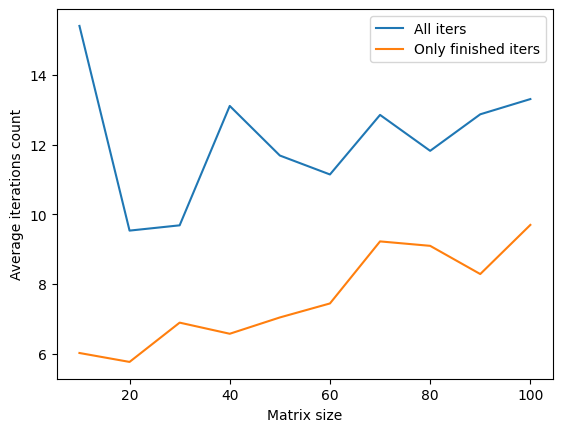

In [ ]:
stats["avg_iter_cnt"].plot()
stats["avg_norm_iter_cnt"].plot()
plt.xlabel("Matrix size")
plt.ylabel("Average iterations count")
plt.legend(["All iters", "Only finished iters"])

Text(0, 0.5, 'Average computation time, ms')

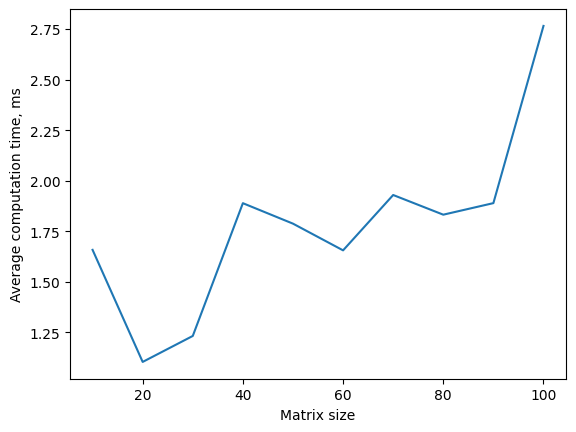

In [ ]:
stats["avg_time"].plot()
plt.xlabel("Matrix size")
plt.ylabel("Average computation time, ms")

С ростом размерности данных время (и число итераций, необходимых для сходимости) растут.

Зависимость точности от числа итераций:

In [ ]:
n_cur = 10
i_cur = 5
start_cur = 0

a = data[n_cur][i_cur]["A"]
u, s, vt = np.linalg.svd(a)
beta = s[0]
alpha = s[-1]
nu = 2 / (alpha + beta)

errs = []
x = data[n_cur][i_cur][f"x_{start_cur}"]
y = fu_obj(a)(x)
iter_num = 0

while not np.isclose(y, data[n_cur][i_cur]["y_true"], atol=eps):
    errs.append(np.linalg.norm(y - data[n_cur][i_cur]["y_true"]))
    if iter_num == max_iter:
        break
    x -= nu * fu_obj_grad(a)(x)
    x = make_projection(x)
    y = fu_obj(a)(x)
    iter_num += 1

Text(0, 0.5, 'Absolute error')

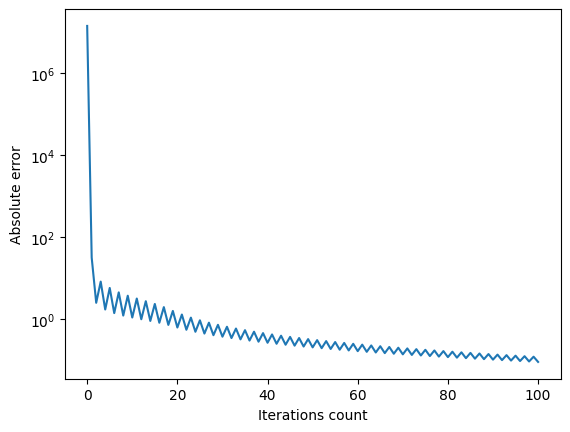

In [ ]:
pd.Series(errs).plot()
plt.yscale("log")
plt.xlabel("Iterations count")
plt.ylabel("Absolute error")

С увеличением числа итераций точность имеет тренд к уменьшению, но в некоторых случаях "блуждания" (как на картинке) оптимальное решение так и не достигается.

Посмотрим на зависимость сорости сходимости от отношения собственных чисел:

<Axes: xlabel='sing_frac', ylabel='conv_rate'>

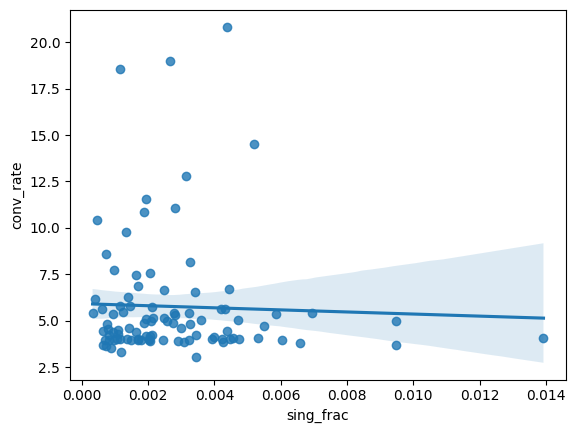

In [ ]:
df = pd.DataFrame({"sing_frac": [data[10][i]["sing_frac"] for i in range(N)],
                   "conv_rate": [data[10][i]["conv_rate"] for i in range(N)],})
df = df.loc[df["conv_rate"] < 95]
sns.regplot(df, y="conv_rate", x="sing_frac")

<Axes: xlabel='sing_frac', ylabel='conv_rate'>

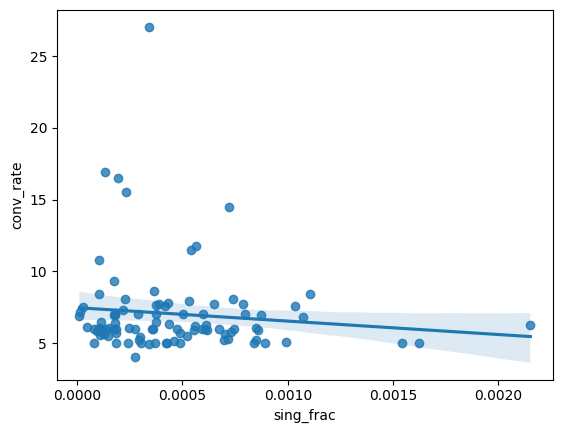

In [ ]:
df = pd.DataFrame({"sing_frac": [data[50][i]["sing_frac"] for i in range(N)],
                   "conv_rate": [data[50][i]["conv_rate"] for i in range(N)],})
df = df.loc[df["conv_rate"] < 95]
sns.regplot(df, y="conv_rate", x="sing_frac")

Как и ожидалось, имеется обратная зависимость между отношением сингулярных чисел и скоростью сходимости градиентного спуска.